In [79]:
import numpy as np
import pandas as pd

import scanpy as sc
from collections import Counter
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score
from tqdm.auto import tqdm
from sklearn.metrics import cohen_kappa_score, f1_score

In [2]:
from numba import set_num_threads

set_num_threads(16)

In [3]:
import pickle
import scvi


Global seed set to 0


https://docs.scvi-tools.org/en/stable/tutorials/notebooks/scarches_scvi_tools.html

# Load data

In [4]:
with open("scvi.model.adult.pickle","rb") as f:
    scvi_model = pickle.load(f)

In [10]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(scvi_model,"Unknown")

/data1/chenyx/anaconda3/envs/sc_R4_Py/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:78: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(
/data1/chenyx/anaconda3/envs/sc_R4_Py/lib/python3.9/site-packages/scvi/data/_utils.py:102: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  warnings.warn(


In [15]:
scanvi_model.train(25,batch_size=4096,use_gpu='cuda:1')

INFO     Training for 25 epochs.                                                             


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Epoch 25/25: 100%|██████████| 25/25 [9:24:31<00:00, 1354.85s/it, loss=4.57e+03, v_num=1]  


In [74]:
scanvi_model.save("/data1/chenyx/NewAnnotation/", overwrite=True)

https://docs.scvi-tools.org/en/stable/tutorials/notebooks/seed_labeling.html

# Query health data

In [10]:
matrix = pd.read_csv("/data1/chenyx/NewAnnotation/UniformedExpression.csv",index_col=0)

In [133]:
metadata = pd.read_csv("/data1/chenyx/NewAnnotation/Healthy.Metadata.csv",index_col=0)
metadata.index = matrix.columns

In [20]:
adata_query = sc.AnnData(X = matrix.transpose(), obs=metadata)
adata_query.var['Gene symbol'] = adata_query.var.index
adata_query.obs["Ref"] = "Query"

/tmp/ipykernel_4058084/3226120225.py:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_query = sc.AnnData(X = matrix.transpose(), obs=metadata)


In [26]:
adata_query.write_h5ad('/data1/chenyx/NewAnnotation/query.h5ad')

## Update with query

In [ ]:
adata_query= sc.read_h5ad('/data1/chenyx/NewAnnotation/query.h5ad')

In [27]:
scvi.model.SCANVI.prepare_query_anndata(adata_query, "/data1/chenyx/NewAnnotation/")

INFO     File /data1/chenyx/NewAnnotation/model.pt already downloaded                        
INFO     Found 99.97037239618943% reference vars in query data.                              


/data1/chenyx/anaconda3/envs/sc_R4_Py/lib/python3.9/site-packages/scvi/model/base/_archesmixin.py:211: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_padding = AnnData(


In [28]:
adata_query

AnnData object with n_obs × n_vars = 24733 × 43878
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Sample', 'Sample_status', 'location', 'organ', 'percent.mt', 'RNA_snn_res.0.3', 'seurat_clusters', 'Layer1', 'Layer2', 'Layer3', 'Ref'
    var: 'Gene symbol'

In [29]:
adata_query.obs['cell_type'] ="Unknown"
vae_q = scvi.model.SCANVI.load_query_data(
    adata_query,
    "/data1/chenyx/NewAnnotation/",
)

INFO     File /data1/chenyx/NewAnnotation/model.pt already downloaded                        


/data1/chenyx/anaconda3/envs/sc_R4_Py/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:78: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(


In [30]:
vae_q.train(
    max_epochs=100,
    plan_kwargs=dict(weight_decay=0.0),
    check_val_every_n_epoch=10,
    use_gpu='cuda:1'
)

INFO     Training for 100 epochs.                                                            


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Epoch 100/100: 100%|██████████| 100/100 [08:25<00:00,  5.06s/it, loss=4.93e+03, v_num=1]


In [31]:
adata_query.obsm["X_scANVI"] = vae_q.get_latent_representation()

In [32]:
predictions = vae_q.predict()

In [33]:
sc.pp.neighbors(adata_query, use_rep="X_scANVI")
sc.tl.leiden(adata_query)
sc.tl.umap(adata_query)

In [34]:
adata_query.obs["prediction"] = predictions

In [91]:
adata_query.write_h5ad('/data1/chenyx/NewAnnotation/predicted.h5ad')

## Visualization

In [ ]:
adata_query = sc.read_h5ad('/data1/chenyx/NewAnnotation/predicted.h5ad')

In [134]:
np.unique(adata_query.obs.Layer2,return_counts=True)

(array(['B cell', 'Basement membrane fibroblast',
        'Capillary endothelial cell', 'Cardiomyocyte cell',
        'Endocardial cell', 'Lymphatic endothelial cell', 'Macorphage',
        'Monocyte', 'Myofibroblast', 'NK cell', 'Neutrophilic granulocyte',
        'Pericyte', 'Smooth muscle cell', 'T cell',
        'Vascular endothelial cell'], dtype=object),
 array([  89, 4347, 3918,  460,   83,   17, 9116,  362,   23,  450,  758,
        1384,  603, 2757,  366]))

In [135]:
np.unique(adata_query.obs.prediction,return_counts=True)

(array(['Adipocyte', 'Basement membrane fibroblast',
        'Capillary endothelial cell', 'Cardiomyocyte cell', 'Macrophage',
        'Monocyte', 'NK cell', 'Pericyte', 'Smooth muscle cell',
        'Vascular endothelial cell'], dtype=object),
 array([  46, 4255, 3975,  459, 5468, 4632, 3464, 1446,  507,  481]))

In [224]:
adata_query.obs['prediction_Layer3'] = list(adata_query.obs.prediction.values)
adata_query.obs['prediction_Layer2'] = list(adata_query.obs.prediction.values)
adata_query.obs['prediction_Layer1'] = list(adata_query.obs.prediction.values)
adata_query.obs.prediction_Layer1[adata_query.obs.prediction == 'Basement membrane fibroblast'] = "Fibroblast"
adata_query.obs.prediction_Layer1[adata_query.obs.prediction == 'Capillary endothelial cell'] = "Endothelial cell"
adata_query.obs.prediction_Layer1[adata_query.obs.prediction == 'Vascular endothelial cell'] = "Endothelial cell"
adata_query.obs.prediction_Layer1[adata_query.obs.prediction == 'Macrophage'] = "Myeloid cell"
adata_query.obs.prediction_Layer1[adata_query.obs.prediction == 'Monocyte'] = "Myeloid cell"
adata_query.obs.prediction_Layer1[adata_query.obs.prediction == 'NK cell'] = "Lymphoid cell"

/tmp/ipykernel_4058084/2426105498.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata_query.obs.prediction_Layer1[adata_query.obs.prediction == 'Basement membrane fibroblast'] = "Fibroblast"
/tmp/ipykernel_4058084/2426105498.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata_query.obs.prediction_Layer1[adata_query.obs.prediction == 'Capillary endothelial cell'] = "Endothelial cell"
/tmp/ipykernel_4058084/2426105498.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

In [148]:
adata_query.uns['prediction_Layer2_colors'] = ['#aa40fc',
 "#8dd593",
 '#8595e1',
 '#8e063b',
 '#e07b91',
 '#d33f6a',
 '#ef9708',
 '#f79cd4',
 '#f6c4e1',
 '#7d87b9'
]

adata_query.uns['Layer2_colors'] = ['#9cded6',
 "#8dd593",
 '#8595e1',
 '#8e063b',
 '#023fa5',
 '#4a6fe3',                                 
 '#e07b91',
 '#d33f6a',
 '#279e68',
 '#ef9708',
 '#f79cd4',
 '#f6c4e1',
 '#ff7f0e',
 '#7d87b9'
]

adata_query.uns['prediction_Layer1_colors'] = ['#aa40fc',
 '#8e063b',
 '#023fa5',
 '#11c638',
 '#ffbb78',
 '#e07b91',
 '#f79cd4',
 '#f6c4e1'
]


adata_query.uns['Layer1_colors'] = ['#8e063b',
 '#023fa5',
 '#11c638',
 '#ffbb78',
 '#e07b91',
 '#f79cd4',
 '#f6c4e1'
]

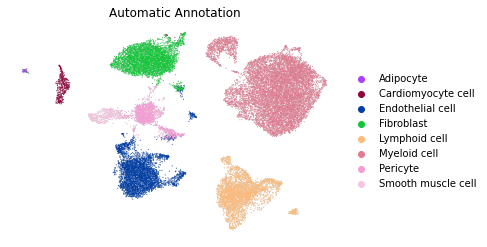

In [141]:
ax = sc.pl.umap(
    adata_query,
    frameon=False,
    show=False,
)

sc.pl.umap(
    adata_query[:adata_query.n_obs],
    color=["prediction_Layer1"],
    frameon=False,
    title="Automatic Annotation",
    ax=ax,
    alpha=0.7,
    save="Automatic.Layer1.Annotation.pdf"
)

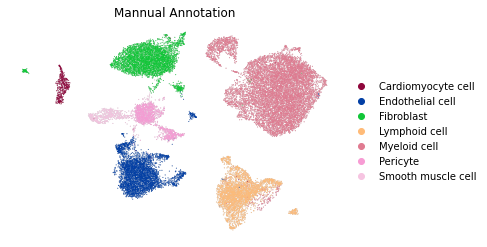

In [142]:
ax = sc.pl.umap(
    adata_query,
    frameon=False,
    show=False,
)
sc.pl.umap(
    adata_query[:adata_query.n_obs],
    color=["Layer1"],
    frameon=False,
    title="Mannual Annotation",
    ax=ax,
    alpha=0.7,
    save="Mannual.Layer1.Annotation.pdf"
)

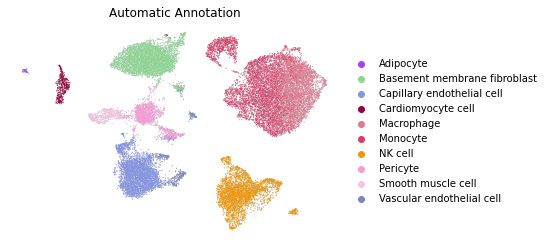

In [143]:
ax = sc.pl.umap(
    adata_query,
    frameon=False,
    show=False,
)
sc.pl.umap(
    adata_query[:adata_query.n_obs],
    color=["prediction_Layer2"],
    frameon=False,
    title="Automatic Annotation",
    ax=ax,
    alpha=0.7,
    save = "Automatic.Layer2.Annotation.pdf"
)

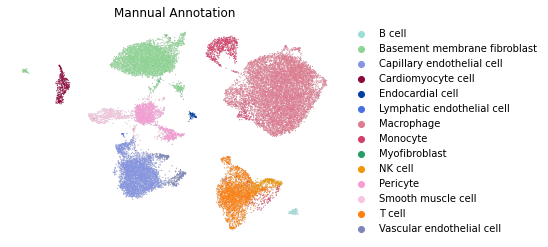

In [149]:
ax = sc.pl.umap(
    adata_query,
    frameon=False,
    show=False,
)
sc.pl.umap(
    adata_query[:adata_query.n_obs],
    color=["Layer2"],
    frameon=False,
    title="Mannual Annotation",
    ax=ax,
    alpha=0.7,
    save = "Mannual.Layer2.Annotation.pdf"
)

In [ ]:
['Adipocyte', '#aa40fc'
 'Adventitial fibroblast', '#b5bbe3'
 'B cell', '#9cded6'
 'Basement membrane fibroblast', '#8dd593'
 'Capillary endothelial cell', '#8595e1'
 'Cardiomyocyte cell', '#8e063b'
 'Cytotoxic CD8 T cell',  '#c6dec7'
 'Endothelial cell',   '#023fa5'
 'Fibroblast',  '#11c638'
 'Lymphatic endothelial cell',  '#4a6fe3'
 'Lymphoid cell', '#ffbb78'
 'Macrophage','#e07b91'
 'Mast cell', '#f3e1eb'
 'Memory CD4 T cell',  '#ead3c6',
 'Mesothelial cell', '#aec7e8'
 'Monocyte','#d33f6a'
 'Myofibroblast', '#279e68'
 'NK T cell', '#f0b98d'
 'NK cell', '#ef9708'
 'Neuron', '#7f7f7f'
 'Neutrophilic granulocyte', '#e6afb9'
 'Pericyte', '#f79cd4' 
 'Smooth muscle cell', '#f6c4e1'
 'T cell', '#ff7f0e'
 'Vascular endothelial cell'] '#7d87b9'

## evaluate

In [150]:
adata_query.obs["Layer1"] = pd.factorize(adata_query.obs["Layer1"].values,)
adata_query.obs["prediction_Layer1"] = list(adata_query.obs["prediction_Layer1"].values)

adata_query.obs["Layer2"] = list(adata_query.obs["Layer2"].values)
adata_query.obs["prediction_Layer2"] = list(adata_query.obs["prediction_Layer2"].values)

In [192]:
adata_query.obs["Layer1"] = pd.Categorical(adata_query.obs["Layer1"],categories=['Adipocyte', 'Cardiomyocyte cell', 'Endothelial cell',
       'Fibroblast', 'Lymphoid cell', 'Myeloid cell', 'Pericyte',
       'Smooth muscle cell'])
adata_query.obs["prediction_Layer1"] = pd.Categorical(adata_query.obs["prediction_Layer1"],categories=['Adipocyte', 'Cardiomyocyte cell', 'Endothelial cell',
       'Fibroblast', 'Lymphoid cell', 'Myeloid cell', 'Pericyte',
       'Smooth muscle cell']) 

### layer 1

In [287]:
df = adata_query.obs.groupby(["prediction_Layer1","Layer1",]).size().unstack(fill_value=0)
norm_df = df / df.sum(axis=0)

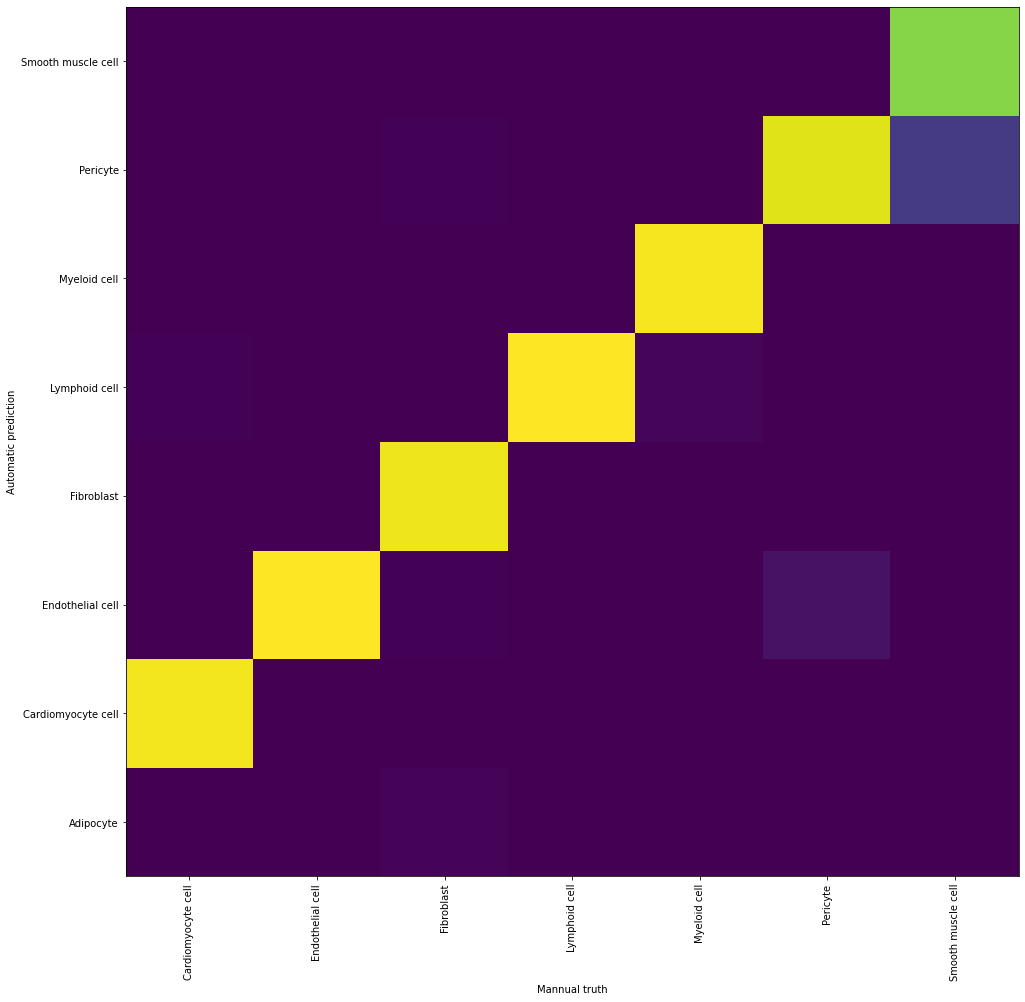

In [288]:
plt.figure(figsize=(16, 16))
_ = plt.pcolor(norm_df.iloc[:,1:])
_ = plt.xticks(np.arange(0.5, len(norm_df.columns)-1, 1), df.columns[1:], rotation=90)
_ = plt.yticks(np.arange(0.5, len(norm_df.index), 1), df.index)
plt.ylabel("Automatic prediction")
plt.xlabel("Mannual truth")
plt.savefig("figures/confusionmatrix_layer1.withoutcol1.pdf")

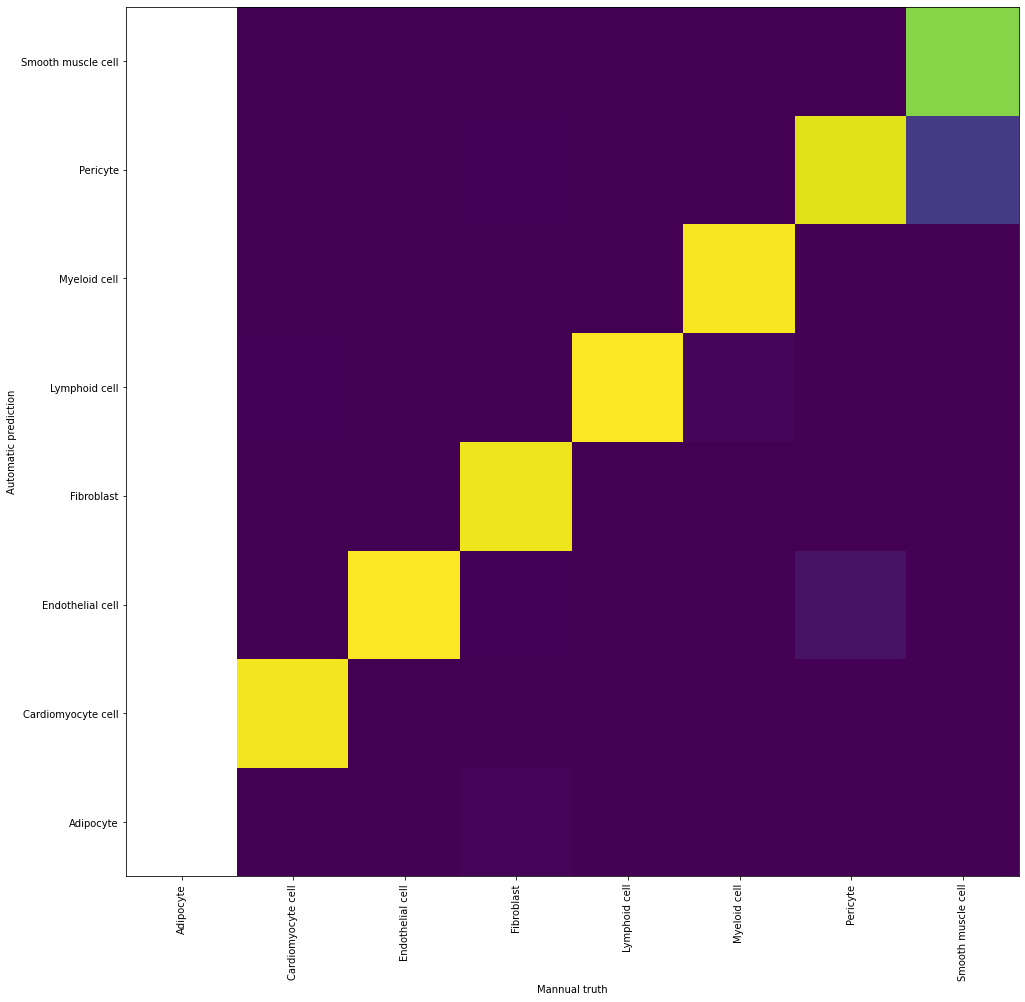

In [289]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 16))
_ = plt.pcolor(norm_df)
_ = plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns, rotation=90)
_ = plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.ylabel("Automatic prediction")
plt.xlabel("Mannual truth")
plt.savefig("figures/confusionmatrix_layer1.pdf")

In [268]:
cohen_kappa_score(adata_query.obs["Layer1"], adata_query.obs["prediction_Layer1"])

0.9743602733457907

In [269]:
f1_score(adata_query.obs["Layer1"], adata_query.obs["prediction_Layer1"],average='weighted')

0.9817275455765303

### layer 2

In [283]:
adata_query.obs["Layer2"] = pd.Categorical(adata_query.obs["Layer2"],categories=['Adipocyte','B cell', 'Basement membrane fibroblast',
       'Capillary endothelial cell', 'Cardiomyocyte cell',
       'Endocardial cell', 'Lymphatic endothelial cell', 'Macrophage',
       'Monocyte', 'Myofibroblast', 'NK cell', 'T cell','Pericyte',
       'Smooth muscle cell',  'Vascular endothelial cell'],ordered=True)
adata_query.obs["prediction_Layer2"] = pd.Categorical(adata_query.obs["prediction_Layer2"],categories=['Adipocyte','B cell', 'Basement membrane fibroblast',
       'Capillary endothelial cell', 'Cardiomyocyte cell',
       'Endocardial cell', 'Lymphatic endothelial cell', 'Macrophage',
       'Monocyte', 'Myofibroblast', 'NK cell', 'T cell', 'Pericyte',
       'Smooth muscle cell', 'Vascular endothelial cell'],ordered=True) 

In [293]:
df = adata_query.obs.groupby(["prediction_Layer2","Layer2",]).size().unstack(fill_value=0)
norm_df = df / df.sum(axis=0)

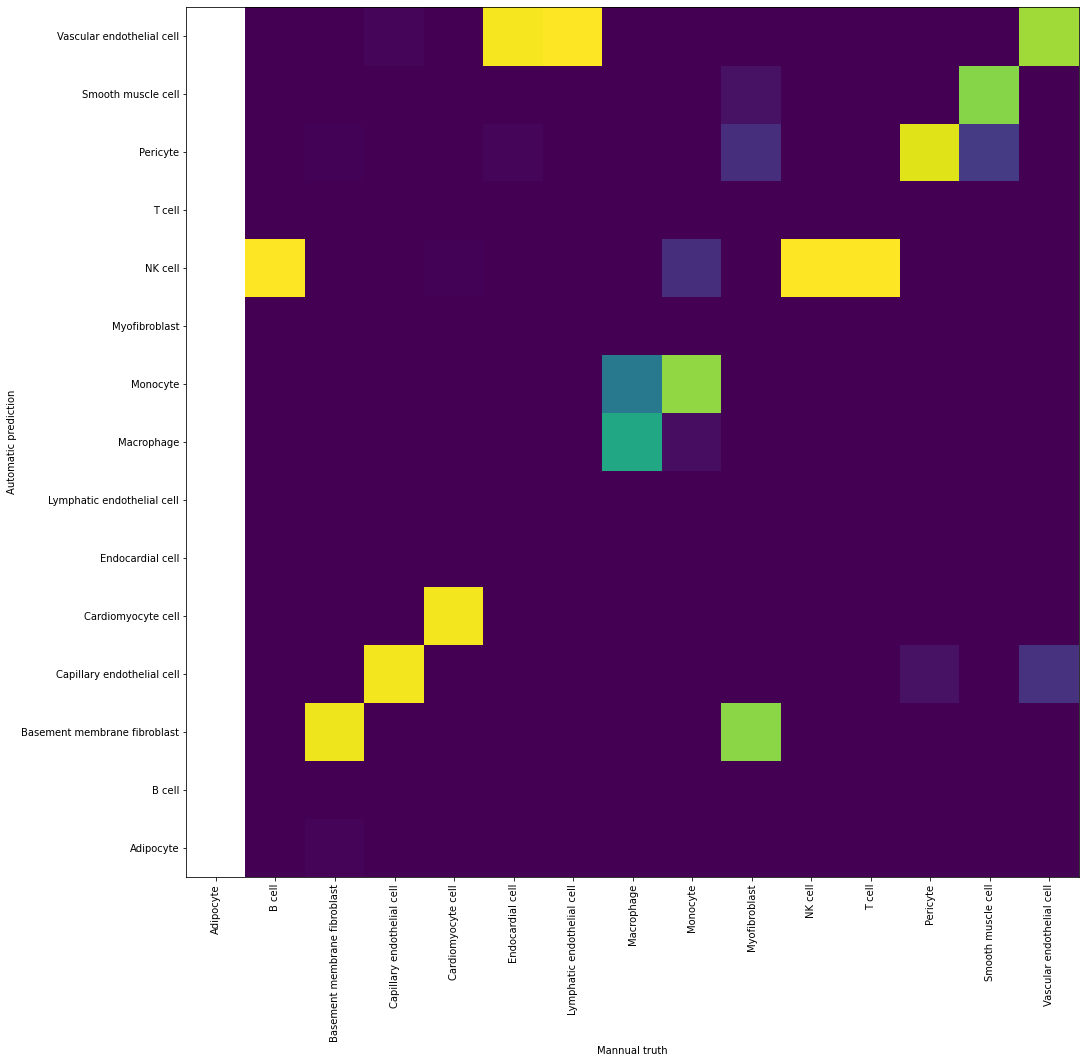

In [294]:
plt.figure(figsize=(16, 16))
_ = plt.pcolor(norm_df)
_ = plt.xticks(np.arange(0.5, len(norm_df.columns), 1), df.columns, rotation=90)
_ = plt.yticks(np.arange(0.5, len(norm_df.index), 1), df.index)
plt.ylabel("Automatic prediction")
plt.xlabel("Mannual truth")
plt.savefig("figures/confusionmatrix_layer2.pdf")

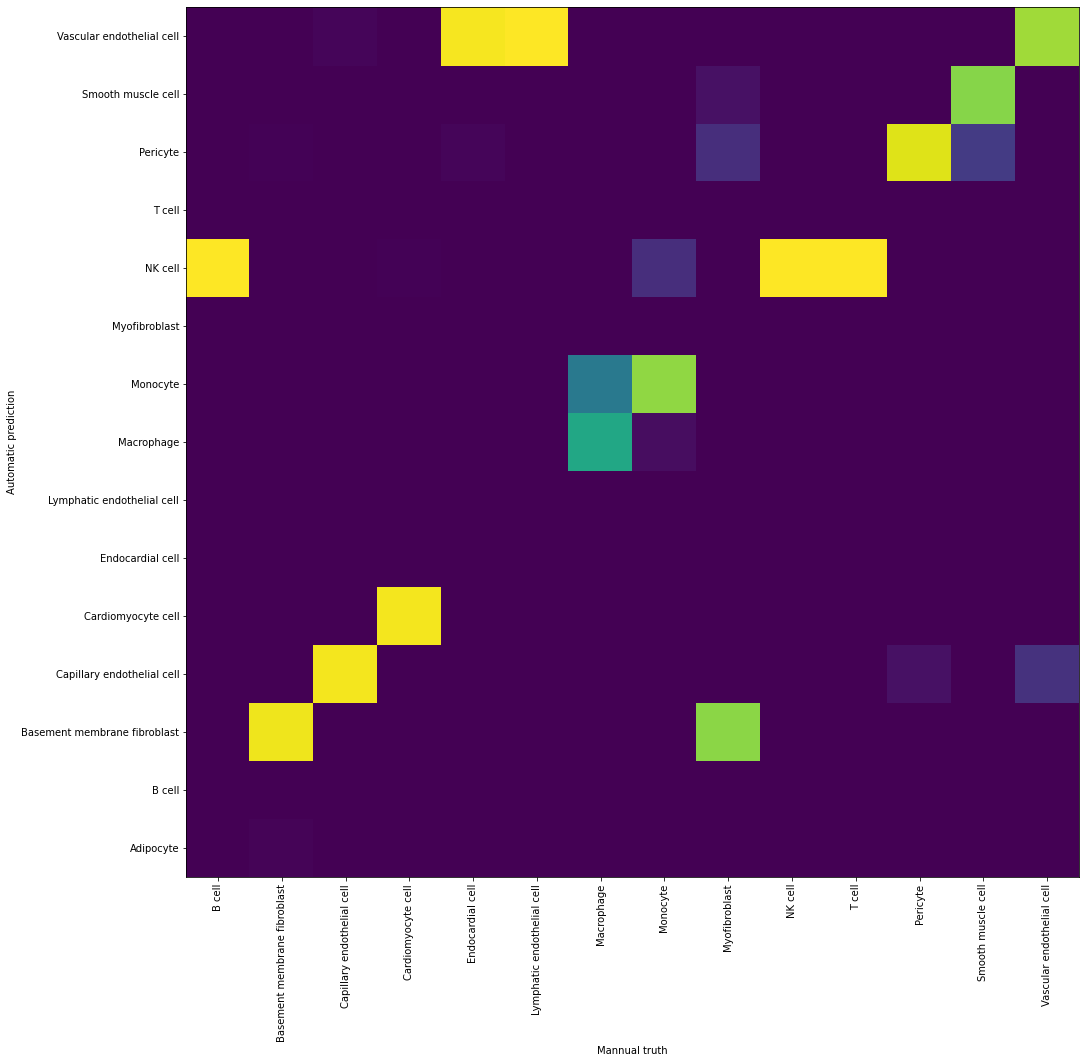

In [295]:
plt.figure(figsize=(16, 16))
_ = plt.pcolor(norm_df.iloc[:,1:])
_ = plt.xticks(np.arange(0.5, len(norm_df.columns)-1, 1), df.columns[1:], rotation=90)
_ = plt.yticks(np.arange(0.5, len(norm_df.index), 1), df.index)
plt.ylabel("Automatic prediction")
plt.xlabel("Mannual truth")
plt.savefig("figures/confusionmatrix_layer2.withoutcol1.pdf")

In [274]:
cohen_kappa_score(adata_query.obs["Layer2"], adata_query.obs["prediction_Layer2"])

0.6533606411892439

In [275]:
f1_score(adata_query.obs["Layer2"], adata_query.obs["prediction_Layer2"],average='weighted')

0.7235701459599506

### Layer2_refined

In [276]:
adata_query.obs['prediction_Layer2_refined'] = list(adata_query.obs.prediction_Layer2.values)
adata_query.obs['Layer2_refined'] = list(adata_query.obs.Layer2.values)

adata_query.obs['prediction_Layer2_refined'][adata_query.obs.prediction_Layer2=="Macrophage"] = "Macrophage/Monocyte"
adata_query.obs['prediction_Layer2_refined'][adata_query.obs.prediction_Layer2=="Monocyte"] = "Macrophage/Monocyte"
adata_query.obs['prediction_Layer2_refined'][adata_query.obs.prediction_Layer2=="NK cell"] = "NK cell/T cell"

adata_query.obs['Layer2_refined'][adata_query.obs.Layer2=="Macrophage"] = "Macrophage/Monocyte"
adata_query.obs['Layer2_refined'][adata_query.obs.Layer2=="Monocyte"] = "Macrophage/Monocyte"
adata_query.obs['Layer2_refined'][adata_query.obs.Layer2=="NK cell"] = "NK cell/T cell"
adata_query.obs['Layer2_refined'][adata_query.obs.Layer2=="T cell"] = "NK cell/T cell"

/tmp/ipykernel_4058084/1985853961.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata_query.obs['prediction_Layer2_refined'][adata_query.obs.prediction_Layer2=="Macrophage"] = "Macrophage/Monocyte"
/tmp/ipykernel_4058084/1985853961.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata_query.obs['prediction_Layer2_refined'][adata_query.obs.prediction_Layer2=="Monocyte"] = "Macrophage/Monocyte"
/tmp/ipykernel_4058084/1985853961.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_

In [277]:
adata_query.obs["Layer2_refined"] = pd.Categorical(adata_query.obs["Layer2_refined"],categories=['Adipocyte','B cell', 'Basement membrane fibroblast',
       'Capillary endothelial cell', 'Cardiomyocyte cell',
       'Endocardial cell', 'Lymphatic endothelial cell', 'Macrophage/Monocyte', 'Myofibroblast','NK cell/T cell','Pericyte',
       'Smooth muscle cell',  'Vascular endothelial cell'],ordered=True)
adata_query.obs["prediction_Layer2_refined"] = pd.Categorical(adata_query.obs["prediction_Layer2_refined"],categories=['Adipocyte','B cell', 'Basement membrane fibroblast',
       'Capillary endothelial cell', 'Cardiomyocyte cell',
       'Endocardial cell', 'Lymphatic endothelial cell', 'Macrophage/Monocyte', 'Myofibroblast', 'NK cell/T cell', 'Pericyte',
       'Smooth muscle cell', 'Vascular endothelial cell'],ordered=True) 

In [291]:
df = adata_query.obs.groupby(["prediction_Layer2_refined","Layer2_refined"]).size().unstack(fill_value=0)
norm_df = df / df.sum(axis=0)

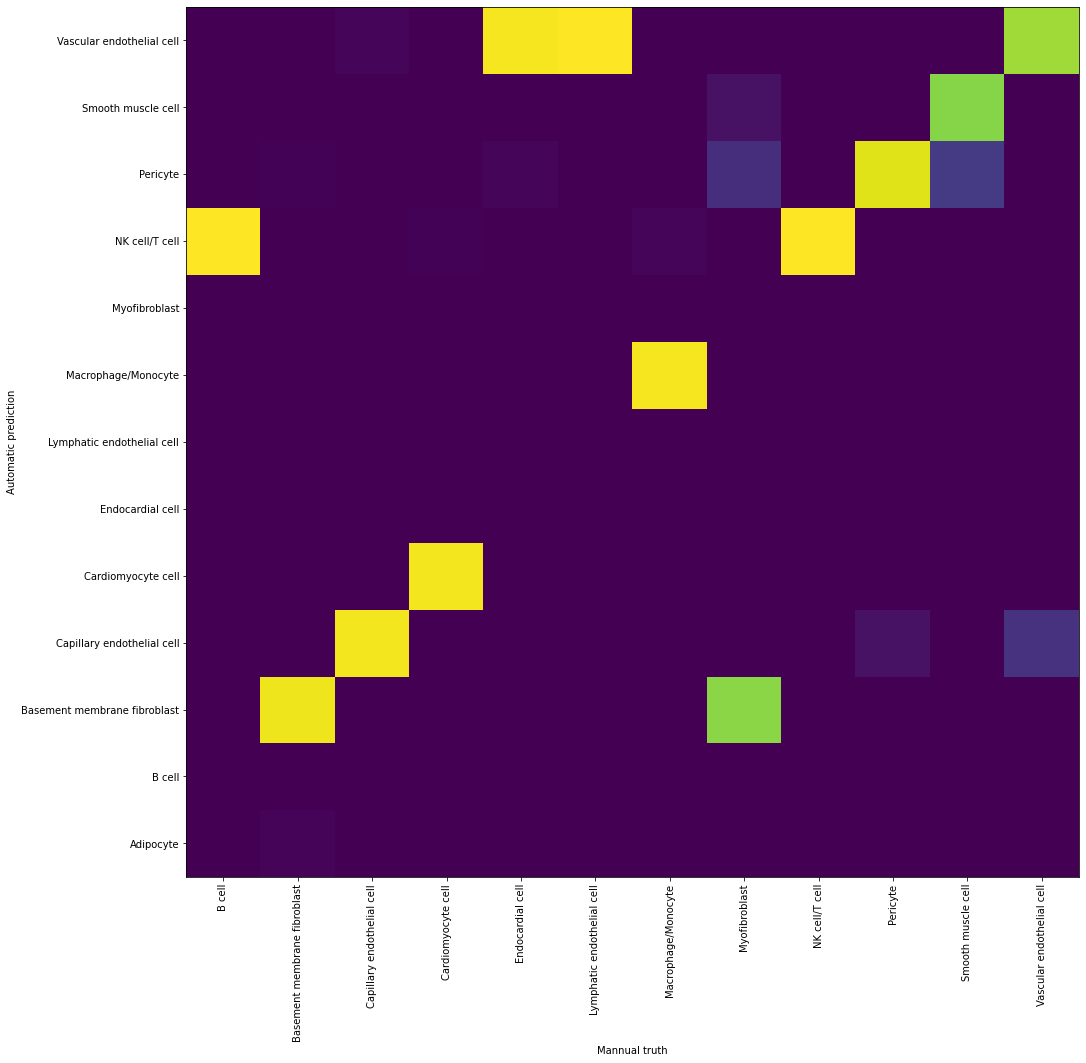

In [292]:
plt.figure(figsize=(16, 16))
_ = plt.pcolor(norm_df.iloc[:,1:])
_ = plt.xticks(np.arange(0.5, len(norm_df.columns)-1, 1), df.columns[1:], rotation=90)
_ = plt.yticks(np.arange(0.5, len(norm_df.index), 1), df.index)
plt.ylabel("Automatic prediction")
plt.xlabel("Mannual truth")
plt.savefig("figures/confusionmatrix_layer2.refined.pdf")

In [280]:
cohen_kappa_score(adata_query.obs["Layer2_refined"], adata_query.obs["prediction_Layer2_refined"])

0.9579425498329202

In [281]:
cohen_kappa_score(adata_query.obs["Layer2_refined"], adata_query.obs["prediction_Layer2_refined"])

0.9579425498329202

In [311]:
adata_query.obs['prediction_Layer2_refined'] = list(adata_query.obs['prediction_Layer2_refined'].values)
adata_query.uns['prediction_Layer2_refined_colors'] = ['#aa40fc',
 "#8dd593",
 '#8595e1',
 '#8e063b',
 '#e07b91',
 '#f0b98d',
 '#f79cd4',
 '#f6c4e1',
 '#7d87b9'
]

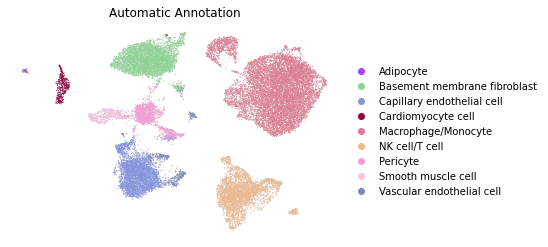

In [314]:
ax = sc.pl.umap(
    adata_query,
    frameon=False,
    show=False,
)
sc.pl.umap(
    adata_query[:adata_query.n_obs],
    color=["prediction_Layer2_refined"],
    frameon=False,
    title="Automatic Annotation",
    ax=ax,
    alpha=0.7,
    save = "Automatic.Layer2.refined.Annotation.pdf"
)

In [317]:
adata_query.obs['Layer2_refined'] = list(adata_query.obs['Layer2_refined'].values)
adata_query.uns['Layer2_refined_colors'] =['#9cded6',
 "#8dd593",
 '#8595e1',
 '#8e063b',
 '#023fa5',
 '#4a6fe3',
 '#e07b91',
 '#279e68',
 '#f0b98d',
 '#f79cd4',
 '#f6c4e1',
 '#7d87b9'
]

In [ ]:
['Adipocyte', '#aa40fc'
 'Adventitial fibroblast', '#b5bbe3'
 'B cell', '#9cded6'
 'Basement membrane fibroblast', "#8dd593"
 'Capillary endothelial cell', '#8595e1'
 'Cardiomyocyte cell', '#8e063b'
 'Cytotoxic CD8 T cell',  '#c6dec7'
 'Endothelial cell',   '#023fa5'
 'Fibroblast',  '#11c638'
 'Lymphatic endothelial cell',  '#4a6fe3'
 'Lymphoid cell', '#ffbb78'
 'Macrophage','#e07b91'
 'Mast cell', '#f3e1eb'
 'Memory CD4 T cell',  '#ead3c6',
 'Mesothelial cell', '#aec7e8'
 'Monocyte','#d33f6a'
 'Myofibroblast', '#279e68'
 'NK T cell', '#f0b98d'
 'NK cell', '#ef9708'
 'Neuron', '#7f7f7f'
 'Neutrophilic granulocyte', '#e6afb9'
 'Pericyte', '#f79cd4' 
 'Smooth muscle cell', '#f6c4e1'
 'T cell', '#ff7f0e'
 'Vascular endothelial cell', '#7d87b9'] 

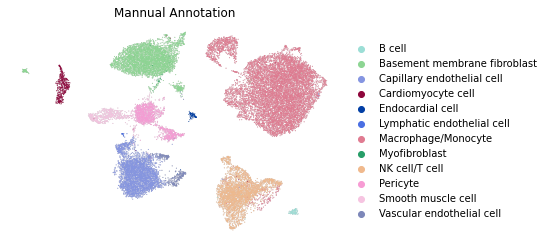

In [318]:
ax = sc.pl.umap(
    adata_query,
    frameon=False,
    show=False,
)
sc.pl.umap(
    adata_query[:adata_query.n_obs],
    color=["Layer2_refined"],
    frameon=False,
    title="Mannual Annotation",
    ax=ax,
    alpha=0.7,
    save = "Mannual.Layer2.Annotation_refined.pdf"
)